# Optimizing bandwidth

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random, jacfwd, jacrev
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

from svgd import SVGD
from metrics import ksd
import time

cpu


/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
n=100
d=1
stepsize = 0.01
svgd_stepsize = stepsize
n_iter_max = 500 # 100 slightly to little, this should be all right
# grid_length = 25
bandwidth = 1

from jax.scipy.stats import norm

@jit
def logp(x):
    assert x.ndim == 1
    return np.sum(norm.logpdf(x, loc=0, scale=1)) 

from svgd import get_bandwidth

svgd_fix = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))
svgd_ada = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=True,  get_bandwidth=get_bandwidth, particle_shape=(n, d))

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Helper functions

In [3]:
def optimize_bandwidths_jointly(self, bandwidth, stepsize, n_steps, sample_every_step=True, gradient_clip_threshold=10):
    """Find optimal bandwidth using SGD.
    Not pure (mutates self.rkey)"""
    if self.adaptive_kernel:
        raise ValueError("This SVGD instance uses an adaptive bandwidth parameter.")
    log = [bandwidth]
    for _ in tqdm(range(n_steps)):
        if sample_every_step:
            self.newkey()
        else:
            pass
        bandwidth = self.step(self.rkey, bandwidth, stepsize, ksd_bandwidth=bandwidth, gradient_clip_threshold=gradient_clip_threshold)
        if np.any(np.isnan(bandwidth)):
            raise Exception(f"Gradient is NaN. Last non-NaN value of bandwidth was {log[-1]}")
        elif np.any(bandwidth < 0):
            print(f"Note: some entries are below zero. Bandwidth = {bandwidth}.")
        else:
            pass
        log.append(bandwidth)
    return bandwidth, log


### Test learned $h$ vs adaptive $h$

In [4]:
def get_metrics(xout, ksd_bandwidths):
    ksds = []
    for h in ksd_bandwidths:
        ksds.append(ksd(xout, logp, h))
        
    metrics = np.array(ksds)
    return metrics

In [5]:
def compare_ada_and_opt(ksd_bandwidths, h_init, meta_stepsize):
    # adaptive
    xout_ada, log_ada = svgd_ada.svgd(svgd_ada.rkey, stepsize, bandwidth=0, n_iter=n_iter_max)
    
    # optimized
    h_opt, hist = svgd_fix.optimize_bandwidth(h_init, meta_stepsize, n_steps=20)
    xout_fix, log = svgd_fix.svgd(svgd_fix.rkey, stepsize, bandwidth=h_opt, n_iter=n_iter_max)
    
    metrics_fix, metrics_ada = [get_metrics(xout, ksd_bandwidths) for xout in [xout_fix, xout_ada]]
    
    return metrics_fix, metrics_ada

In [6]:
ksd_bandwidths = [1, 2, 3]
h_init = 3.
meta_stepsize = 0.1

In [7]:
metrics = compare_ada_and_opt(ksd_bandwidths, h_init, meta_stepsize)
metrics

JIT COMPILING...
Done compiling in 0.39179015159606934 seconds.


  0%|          | 0/20 [00:00<?, ?it/s]

JIT COMPILING step...
JIT COMPILING...
Done compiling in 1.3120131492614746 seconds.
...done compiling after 1.463364601135254 seconds.


  5%|▌         | 1/20 [00:13<04:15, 13.45s/it]

JIT COMPILING step...
JIT COMPILING...
Done compiling in 1.1921422481536865 seconds.
...done compiling after 1.1972248554229736 seconds.


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


JIT COMPILING...
Done compiling in 0.11555600166320801 seconds.


(DeviceArray([1.0267235 , 0.1214558 , 0.02712556], dtype=float32),
 DeviceArray([0.00825037, 0.0076002 , 0.0065922 ], dtype=float32))

In [8]:
metrics2 = compare_ada_and_opt(ksd_bandwidths, h_init, meta_stepsize)
metrics2

100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


(DeviceArray([0.00892288, 0.00091078, 0.00080097], dtype=float32),
 DeviceArray([0.00825037, 0.0076002 , 0.0065922 ], dtype=float32))

In [9]:
metrics3 = compare_ada_and_opt(ksd_bandwidths, h_init, meta_stepsize)
metrics3

100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


(DeviceArray([0.18666881, 0.00348612, 0.00225773], dtype=float32),
 DeviceArray([0.00825037, 0.0076002 , 0.0065922 ], dtype=float32))

# 1-d

In [18]:
meta_stepsize = 100
n_steps = 50
h = 25
opt_h, log1 = svgd_fix.optimize_bandwidth(h, meta_stepsize, n_steps)

print("value:", opt_h)

100%|██████████| 50/50 [00:12<00:00,  3.90it/s]

value: 21.537348


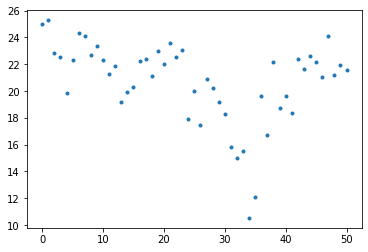

In [19]:
plt.plot(log1, ".")

In [20]:
h = 3
meta_stepsize = 0.1
opt_h, log = svgd_fix.optimize_bandwidth(h, meta_stepsize, n_steps)
print("value:", opt_h)
# print(f"loss at {opt_h}:", svgd_fix.loss(rkey, opt_h))

  0%|          | 0/50 [00:00<?, ?it/s]

JIT COMPILING step...
...done compiling after 0.005913734436035156 seconds.


100%|██████████| 50/50 [00:23<00:00,  2.12it/s]

value: 0.98194677


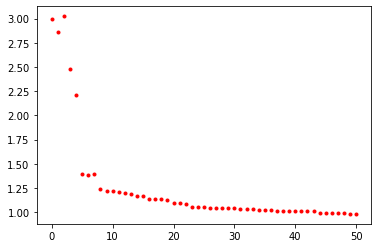

In [21]:
plt.plot(log, "r.")

Conclusion: gradient descent is succesful in finding decent local minima. But since the objective function (KSD) is nonconvex, it does sometimes get stuck in globally suboptimal spots.

## GD with joint parameters

In [15]:
def optimize_bandwidths_jointly(self, bandwidth, stepsize, n_steps, sample_every_step=True, gradient_clip_threshold=10):
    """Find optimal bandwidth using SGD.
    Not pure (mutates self.rkey)"""
    if self.adaptive_kernel:
        raise ValueError("This SVGD instance uses an adaptive bandwidth parameter.")
    log = [bandwidth]
    for _ in tqdm(range(n_steps)):
        if sample_every_step:
            self.newkey()
        else:
            pass
        bandwidth = self.step(self.rkey, bandwidth, stepsize, ksd_bandwidth=bandwidth, gradient_clip_threshold=gradient_clip_threshold)
        if np.any(np.isnan(bandwidth)):
            raise Exception(f"Gradient is NaN. Last non-NaN value of bandwidth was {log[-1]}")
        elif np.any(bandwidth < 0):
            print(f"Note: some entries are below zero. Bandwidth = {bandwidth}.")
        else:
            pass
        log.append(bandwidth)
    return bandwidth, log


In [16]:
h = 3
meta_stepsize = 1
opt_hj, logj = optimize_bandwidths_jointly(svgd_fix, h, meta_stepsize, 50)
print("value:", opt_hj)

  0%|          | 0/50 [00:00<?, ?it/s]

JIT COMPILING step...
...done compiling after 0.004057168960571289 seconds.


  2%|▏         | 1/50 [00:12<09:57, 12.20s/it]

JIT COMPILING step...
...done compiling after 0.12403273582458496 seconds.


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]

value: 1.37057


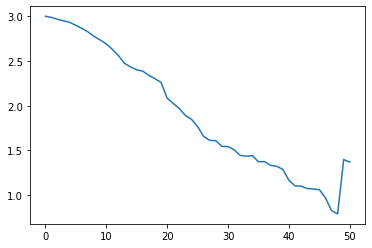

In [17]:
plt.plot(logj)

In [22]:
h = 20
meta_stepsize = 1
opt_hj, logj = optimize_bandwidths_jointly(svgd_fix, h, meta_stepsize, 50)
print("value:", opt_hj)

100%|██████████| 50/50 [00:12<00:00,  3.96it/s]

value: 19.999348


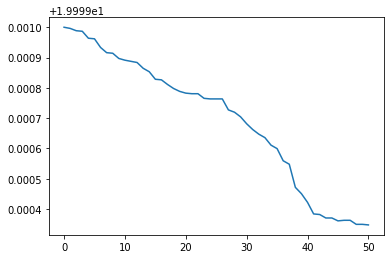

In [23]:
plt.plot(logj)